- na straně 135
- občas klasifikuje špatně, jednu třidu rozdělí na 2 a 2 naopak spojí
- binarní je stabilní na stejných datech, direct není stabilní (náhodný výběr prvotní aproximace centroidů)
- binární se dá vylepšit pomocí iterativní optimalizace, direct vrací vždy výsledky, které nelze vylepšit


U direct:
- !!!!!! nedaří se mi iterativní optimalizaci použít. Mě to z ní vypadává optimální ke zvoleným středům
- !!! pokud si napískám náhodně jiné středy, tak by se to přesouvat chtělo. Ale to bych dělat neměl




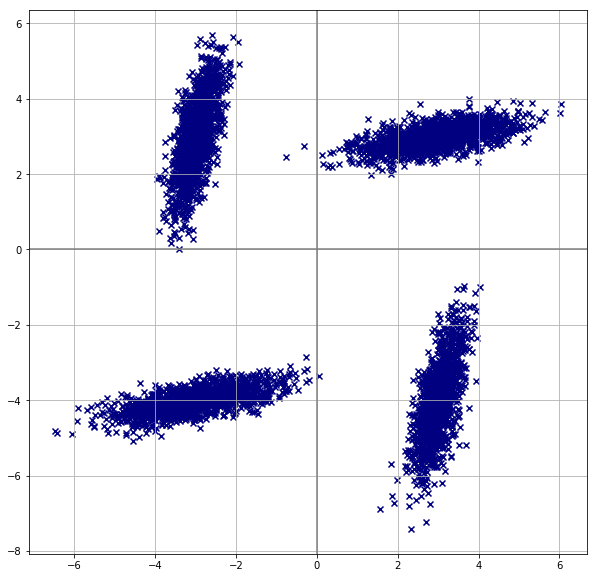

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from tools import dist_m

plt.rcParams['figure.figsize'] = [10, 10]

data = np.genfromtxt('data.txt', delimiter=' ')
data_len = len(data)

plt.scatter(data[:,0],data[:,1], color='navy', marker='x')
plt.grid(True, which='both')
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')


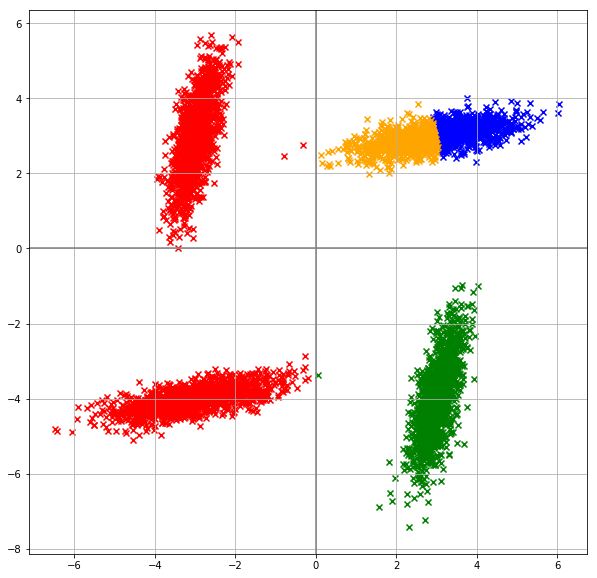

In [89]:
from tools import dist_v, dist_m


# coding: utf-8

import numpy as np
from tools import dist_v

def kmeans(data,cl_nb, eps, mi):
    """
    data ... 2-rozměrná data vzorů
    cl_nb ... počet tříd do kterých klasifikuji
    eps ... zastavovací podmínka pro ukazatel kvality
    
    return ... vektor rozdělení dat do tříd
    """

    # kriteriální funkce (na jejím základě rozhoduji o zastavení iterací)
    J = []

    data_len = len(data)
    #matice vzdáleností v rámci tříd (třídy=sloupce)
    dist_cl = np.full((data_len,cl_nb),np.inf)   

    for j in range(0,20):
        #výpočet metrik v rámci tříd
        for i in range(0,cl_nb):
            dist_cl[:,i]=dist_v(data,mi[i])

        #klasifikace dat do tříd (vektor velikosti data s hodnotou = index třídy)
        data_cl = np.argmin(dist_cl,axis=1)

        # výpočet nových centroidů
        mi = []
        J_temp = 0
        for i in range(0,cl_nb):
            J_temp += np.sum(dist_cl[np.where(data_cl==i),i])
            mi.append(np.average(data[np.where(data_cl==i),:],axis=1))
        J.append(J_temp)
        if len(J) > 1 and np.abs(J[j]-J[j-1]) < eps:
                break

    #asi budu muset z kmeans vracet ne jen masku, ale i rozdělení do tříd, jinak nevím, jak to dělat v rámci jedné masky postupně po 2
    data_classified = []
    for i in range(cl_nb):
        data_classified.append(data[np.where(data_cl==i),:][0])
                
    #provedu iterativní optimalizaci:
    # vstupy: třídy dat Ti, jejich centroidy mii, četnosti si a hodnota kriteriální funkce J
    # procházet všechny prvky všech tříd (postupně) a pokoušet se je přeřadit do tříd ostatních
    # kritérium je poměrně jednoduché porovnávám pokles a nárůst 
    # pokud vyhoví kritériu, tak přesunu a jedu dál
    return data_classified

def kmeans_direct(data_tmp, cl_nb, eps):
    data_classified = kmeans(data_tmp, cl_nb, eps, data_tmp[np.random.choice(len(data_tmp), 4, replace=False)])
    return data_classified

def kmeans_binary(data_tmp, cl_nb, eps):
    data_classified = []
    for i in range(cl_nb-1):
        data_len = len(data_tmp)
        dist_matrix = dist_m(data_tmp) # generuji distanční matici
        max_ind = np.unravel_index(np.nanargmax(dist_matrix, axis=None), dist_matrix.shape) #najdu nejvzdálenější body

        # zavolat pro ně kmeans do 2 tříd
        data_class = kmeans(data_tmp, 2, eps, [data_tmp[max_ind[0],:],data_tmp[max_ind[1],:]])
        # beru větší třídu a na ní volám zase kmeans pro 2 třídy
        if len(data_class[0]) >= len(data_class[1]):
            data_tmp = data_class[0]
            data_classified.append(data_class[1])
        else:
            data_tmp = data_class[1]
            data_classified.append(data_class[0])
    data_classified.append(data_tmp)
    
    return data_classified
 
# počet tříd, do kterých klasifikuji
cl_nb = 4

# ukazatel kvality (na jeho základě rozhoduji o zastavení iterací)
eps = 1.e-03

#data_classified = kmeans_direct(data, cl_nb, eps)
data_classified = kmeans_binary(data, cl_nb, eps)

#vykreslit data do tříd s různějma barvama
plt_col = ['red','green','blue','orange']
for i in range(0,len(data_classified)):
    plt.scatter(data_classified[i][:,0],data_classified[i][:,1], color=plt_col[i], marker='x')
plt.grid(True, which='both')
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.show()


#plt_col = ['red','green','blue','orange']
#for i in range(0,len(data_classified)):
#    plt.scatter(data_classified[i][:,0],data_classified[i][:,1], color=plt_col[i], marker='x')
#plt.grid(True, which='both')
#plt.axhline(y=0, color='gray')
#plt.axvline(x=0, color='gray')
#plt.show()

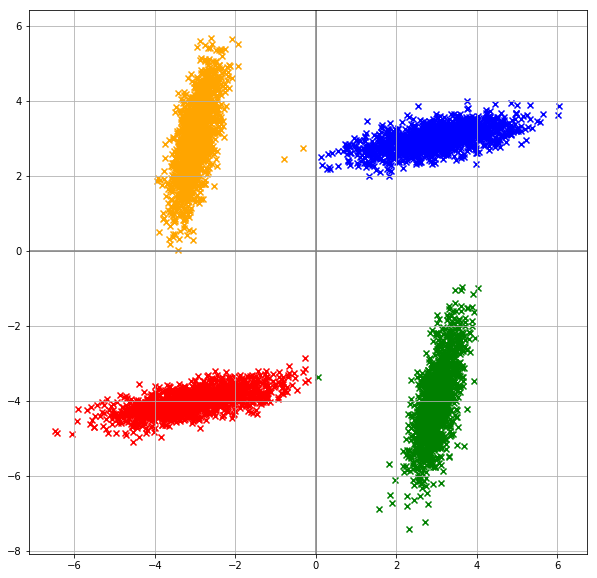

In [90]:

from tools import metric

method = True

while method:
    method = False
    for i in range(cl_nb):
        s = []
        mi = []
        for j in range(cl_nb):
            s.append(len(data_classified[j]))
            mi.append(np.average(data_classified[j],axis=0))

        #s se esmí rovna 1 (jen jeden prvek ve třídě) - jinak bych dělil 0
        if s[i] != 1:
            # pole vzdáleností prvků i-té třídy od středů všech tříd
            Aj_vs = np.full((s[i],cl_nb),np.inf)
            for j in range(0,cl_nb):
                if i==j:
                    coef = s[j]/(s[j]-1)
                else:
                    coef = s[j]/(s[j]+1)
                Aj_vs[:,j]= coef * dist_v(data_classified[i],mi[j])

            #maska kam přesunout jaké body
            move_mask = np.argmin(Aj_vs,axis=1)

            for j in range(cl_nb):
                if j != i:
                    data_move = data_classified[i][np.where(move_mask==j),:]
                    if data_move.shape[1] > 0:
                            method = True
                            data_classified[j] = np.append(data_classified[j], data_move[0], axis=0)
                            cnt = 0
                            for k in range(len(move_mask)):
                                if move_mask[k] == j:
                                    data_classified[i] = np.delete(data_classified[i],k-cnt,axis=0)
                                    cnt += 1
                                    
for i in range(0,len(data_classified)):
    plt.scatter(data_classified[i][:,0],data_classified[i][:,1], color=plt_col[i], marker='x')
plt.grid(True, which='both')
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.show()    